Plot with the new Lyman alpha fits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '../new_lya/'
lyas = glob.glob('{}*results.csv'.format(path))
lyas

['../new_lya/GJ649_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ674_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ15A_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ729_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ849_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ1132_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/LHS2686_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ676A_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ163_LyA_only_CowanSR_MCMC_results.csv']

../new_lya/GJ649_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ674_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ15A_LyA_only_CowanSR_MCMC_results.csv
GJ15A yes
../new_lya/GJ729_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ849_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ1132_LyA_only_CowanSR_MCMC_results.csv
../new_lya/LHS2686_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ676A_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ163_LyA_only_CowanSR_MCMC_results.csv


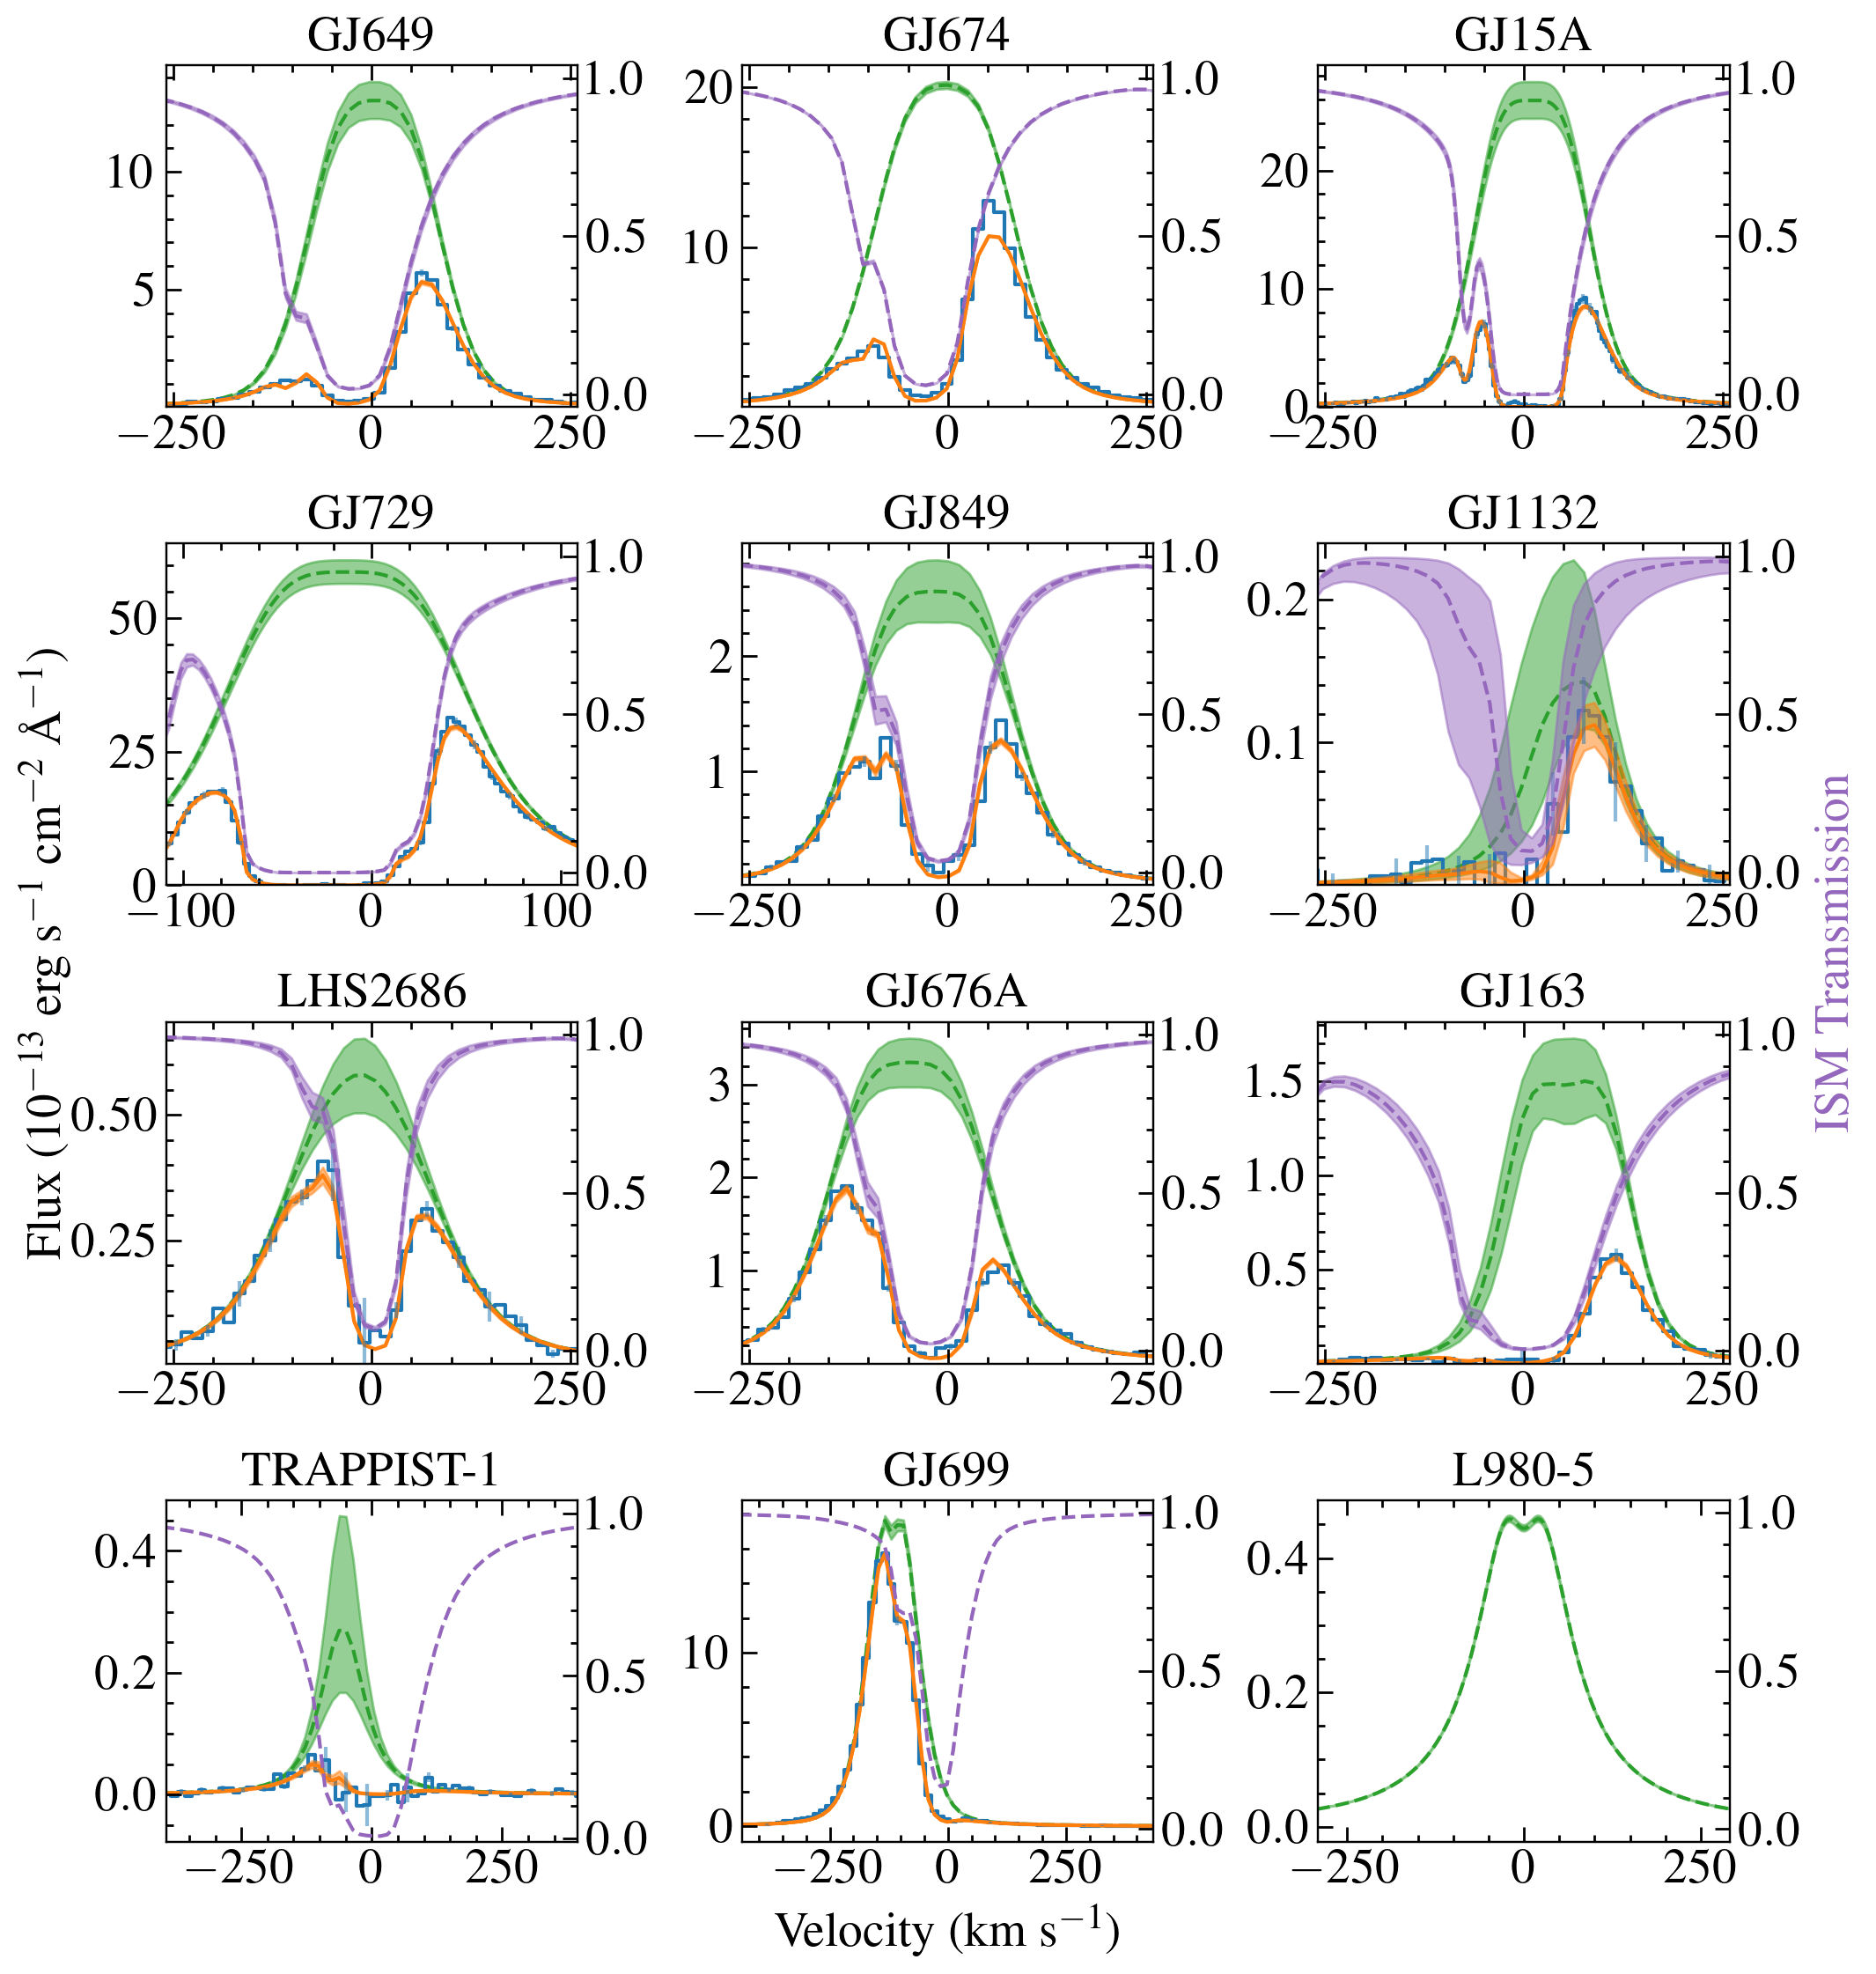

In [26]:
fig, axes = plt.subplots(figsize=(12, 12), nrows=4, ncols=3)
lya = 1215.67
ism_scale = 2.3e-13 #scaling ism to plot
fscale = 1e13 #scaling flux to axis
ism_scale *= fscale

# lyfake = np.hstack((lyas, lyas[0:3])) #adding on three more profiles to test the figure

for i in range(len(lyas)):
    spec = lyas[i]
    print(spec)
    data = Table.read(spec)
    ax = axes.flat[i]
    # print(data['h1_b value'][2])
    v = (data['wave_lya']*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
    ax.step(v, data['flux_lya']*fscale, c='C0', label = 'Observed Spectrum', zorder=0, where='mid')
    ax.errorbar(v, data['flux_lya']*fscale, yerr=data['error_lya']*fscale, alpha=0.5, errorevery=3, ls='none', c='C0')
    ax.plot(v, data['lya_model_median']*fscale, c='C1', label='Model fit', zorder=1)
    ax.fill_between(v.value, data['lya_model_high_1sig']*fscale,data['lya_model_low_1sig']*fscale, color='C1', alpha=0.5)
    
    ax.plot(v, data['lya_intrinsic_median']*fscale, c='C2', ls='--', label=r'Intrinsic Ly$\alpha$ profile', zorder=-1)
    ax.fill_between(v.value, data['lya_intrinsic_high_1sig']*fscale,data['lya_intrinsic_low_1sig']*fscale, color='C2', alpha=0.5, zorder=-10)
    
    name = os.path.split(spec)[1][:-34]
    ax.set_title(name, size=20)

    if name == 'GJ729':
        xlim=  109
    else:
        xlim = 259
    
    # xlim = min([abs(min(v.value)), max(v.value)])-10
    ax.set_xlim(-xlim, xlim)
    ax2=ax.twinx()
    ax2.plot(v, data['lya_ism_median'], c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
    ax2.fill_between(v.value, data['lya_ism_high_1sig'],data['lya_ism_low_1sig'], color='C4', alpha=0.5, zorder=-10)
    ax2.set_ylim(-0.04, 1.04)

    miny, maxy = np.min(data['lya_model_low_1sig']*fscale), np.max(data['lya_intrinsic_high_1sig']*fscale)
    if miny > 0:
        ax.set_ylim(0.5*miny, 1.05*maxy)
    else:
        print(name, 'yes')
        ax.set_ylim(1.5*miny, 1.05*maxy)


    

    
#trappist 1
data = Table.read('../new_lya/TRAPPIST1_MCMC_results.txt', format='csv')
ax = axes.flat[len(lyas)]
# print(data['h1_b value'][2])
v = (data['wave_mm']*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
ax.step(v, data['flux_mm']*fscale, c='C0', label = 'Observed Spectrum', zorder=0, where='mid')
ax.errorbar(v, data['flux_mm']*fscale, yerr=data['error_mm']*fscale, alpha=0.5, errorevery=3, ls='none', c='C0')
ax.plot(v, data['LyA_model_median_mm']*fscale, c='C1', label='Model fit', zorder=1)
ax.fill_between(v.value, data['LyA_model_high_1sig_mm']*fscale,data['LyA_model_low_1sig_mm']*fscale, color='C1', alpha=0.5)

ax.plot(v, data['LyA_intrinsic_profile_median_mm']*fscale, c='C2', ls='--', label=r'Intrinsic Ly$\alpha$ profile', zorder=-1)
ax.fill_between(v.value, data['LyA_intrinsic_profile_high_1sig_mm']*fscale,data['LyA_intrinsic_profile_low_1sig_mm']*fscale, color='C2', alpha=0.5, zorder=-10)

name = 'TRAPPIST-1'
ax.set_title(name, size=20)


ism = data['LyA_model_median_mm'] / data['LyA_intrinsic_profile_median_mm']
# ism_up = ism*(1+((data['LyA_intrinsic_profile_high_1sig_mm'] - data['LyA_intrinsic_profile_median_mm'])/data['LyA_intrinsic_profile_median_mm']))
# ism_dn = ism*(1-((data['LyA_intrinsic_profile_median_mm'] - data['LyA_intrinsic_profile_low_1sig_mm'])/data['LyA_intrinsic_profile_median_mm']))
# ism_up = ism+(1-ism)*((data['LyA_model_high_1sig_mm'] - data['LyA_model_median_mm'])/data['LyA_model_median_mm'])
# ism_dn = ism-ism*((data['LyA_model_median_mm'] - data['LyA_model_low_1sig_mm'])/data['LyA_model_median_mm'])

xlim = min([abs(min(v.value)), max(v.value)])-10
ax.set_xlim(-xlim, xlim)
ax2=ax.twinx()
ax2.plot(v, ism, c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
# ax2.fill_between(v.value, ism_up,ism_dn, color='C4', alpha=0.5, zorder=-10)
ax2.set_ylim(-0.01, 1.04)

#barnard's star

data = Table.read('../new_lya/GJ699_G140M_final_fits.txt', format='csv')
ax = axes.flat[len(lyas)+1]
# print(data['h1_b value'][2])
v = (data['wave']*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
ax.step(v, data['flux']*fscale, c='C0', label = 'Observed Spectrum', zorder=0, where='mid')
ax.errorbar(v, data['flux']*fscale, yerr=data['error']*fscale, alpha=0.5, errorevery=3, ls='none', c='C0')
ax.plot(v, data['best_fit_model']*fscale, c='C1', label='Model fit', zorder=1)
ax.fill_between(v.value, data['model_high_1sig']*fscale,data['model_low_1sig']*fscale, color='C1', alpha=0.5)

ax.plot(v, data['best_fit_intrinsic']*fscale, c='C2', ls='--', label=r'Intrinsic Ly$\alpha$ profile', zorder=-1)
ax.fill_between(v.value, data['intrinsic_high_1sig']*fscale,data['intrinsic_low_1sig']*fscale, color='C2', alpha=0.5, zorder=-10)

name = 'GJ699'
ax.set_title(name, size=20)

modup = np.median((data['intrinsic_high_1sig']-data['best_fit_intrinsic'])/data['best_fit_intrinsic']) #need for L980-5
moddn = np.median((abs(data['intrinsic_low_1sig']-data['best_fit_intrinsic']))/data['best_fit_intrinsic']) #need for L980-5


ism = data['best_fit_model'] / data['best_fit_intrinsic']
# ism_up = ism*(1+((data['LyA_intrinsic_profile_high_1sig_mm'] - data['LyA_intrinsic_profile_median_mm'])/data['LyA_intrinsic_profile_median_mm']))
# ism_dn = ism*(1-((data['LyA_intrinsic_profile_median_mm'] - data['LyA_intrinsic_profile_low_1sig_mm'])/data['LyA_intrinsic_profile_median_mm']))
# ism_up = ism+(1-ism)*((data['LyA_model_high_1sig_mm'] - data['LyA_model_median_mm'])/data['LyA_model_median_mm'])
# ism_dn = ism-ism*((data['LyA_model_median_mm'] - data['LyA_model_low_1sig_mm'])/data['LyA_model_median_mm'])


xlim = min([abs(min(v.value)), max(v.value)])-10
ax.set_xlim(-xlim, xlim)
ax2=ax.twinx()
ax2.plot(v, ism, c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
# ax2.fill_between(v.value, ism_up,ism_dn, color='C4', alpha=0.5, zorder=-10)
ax2.set_ylim(-0.04, 1.04)


#L980-5
data = Table.read('../new_lya/L980-5_lya_basic.txt', format='csv')
ax = axes.flat[len(lyas)+2]
v = (data['WAVELENGTH']*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))

ax.plot(v, data['FLUX']*fscale, c='C2', ls='--', label=r'Intrinsic Ly$\alpha$ profile', zorder=-1)
eup = ((data['FLUX']*modup)+ data['FLUX'])
edn = (data['FLUX']- (data['FLUX']*moddn))

ax.fill_between(v.value, eup*fscale,edn*fscale, color='C2', alpha=0.5, zorder=-10)

name = 'L980-5'
ax.set_title(name, size=20)
xlim = 291
ax.set_xlim(-xlim, xlim)
ax2=ax.twinx()
# ax2.plot(v, ism, c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
# ax2.fill_between(v.value, ism_up,ism_dn, color='C4', alpha=0.5, zorder=-10)
ax2.set_ylim(-0.04, 1.04)









ax1 = fig.add_subplot(111, frame_on=False)
ax1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
# plt.ylabel('Flux ($10^{-14}$\,erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20, labelpad=12)
ax1.set_xlabel('Velocity (km s$^{-1}$)', size=20)
ax1.set_ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20, labelpad=10)

# ax3 = ax1.twinx()
# ax3
# ax3.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
# # ax3.tick_params(axis='y', labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')

# # ax3.axis('off')
# ax3.spines['top'].set_visible(False)
# ax3.spines['right'].set_visible(False)
# ax3.spines['bottom'].set_visible(False)
# ax3.spines['left'].set_visible(False)
# # ax3.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
# ax3.tick_params(axis='y', labelcolor='none', top=False, bottom=False, left=False, right=False, which='minor')

ax3 = fig.add_subplot(111, frame_on=False)
ax3.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
ax3.yaxis.set_label_position("right")

# ax3.set_minior_ticks(visible=False)
ax3.set_ylabel('ISM Transmission', labelpad=35, c='C4')

plt.tight_layout()
fig.subplots_adjust(wspace=0.4, hspace=0.4)
# fig.savefig('plots/lya_test.png')
fig.savefig('plots/all_mm_lya.pdf')

Need to reconsruct the files for Barnad's star, T-1 and L980-5. Don't have ISM. For T-1 assume that the %age error on the ISM is the same as that on the intrinsic flux.

In [4]:
data = Table.read('../new_lya/TRAPPIST1_MCMC_results.txt', format='csv')


In [5]:
data.dtype.names

('col0',
 'wave_mm',
 'flux_mm',
 'error_mm',
 'cont_mm',
 'LyA_intrinsic_profile_low_2sig_mm',
 'LyA_intrinsic_profile_low_1sig_mm',
 'LyA_intrinsic_profile_median_mm',
 'LyA_intrinsic_profile_high_1sig_mm',
 'LyA_intrinsic_profile_high_2sig_mm',
 'LyA_model_low_2sig_mm',
 'LyA_model_low_1sig_mm',
 'LyA_model_median_mm',
 'LyA_model_high_1sig_mm',
 'LyA_model_high_2sig_mm',
 'wave_b',
 'flux_b',
 'error_b',
 'cont_b',
 'model_best_fit_b',
 'LyA_intrinsic_profile_bestfit',
 'LyA_intrinsic_profile_low_2sig_b',
 'LyA_intrinsic_profile_low_1sig_b',
 'LyA_intrinsic_profile_median_b',
 'LyA_intrinsic_profile_high_1sig_b',
 'LyA_intrinsic_profile_high_2sig_b',
 'LyA_model_low_2sig_b',
 'LyA_model_low_1sig_b',
 'LyA_model_median_b',
 'LyA_model_high_1sig_b',
 'LyA_model_high_2sig_b',
 'LyA_intrinsic_flux_low_2sig_mm',
 'LyA_intrinsic_flux_low_1sig_mm',
 'LyA_intrinsic_flux_median_mm',
 'LyA_intrinsic_flux_high_1sig_mm',
 'LyA_intrinsic_flux_high_2sig_mm',
 'LyA_intrinsic_flux_low_2sig_b',
 'L

/tmp/ipykernel_85164/1084684336.py:9: RuntimeWarning: invalid value encountered in sqrt
  isme = (ism * (((me-m)/m)**2 - ((Ie-I)/I)**2)**0.5) #+ism


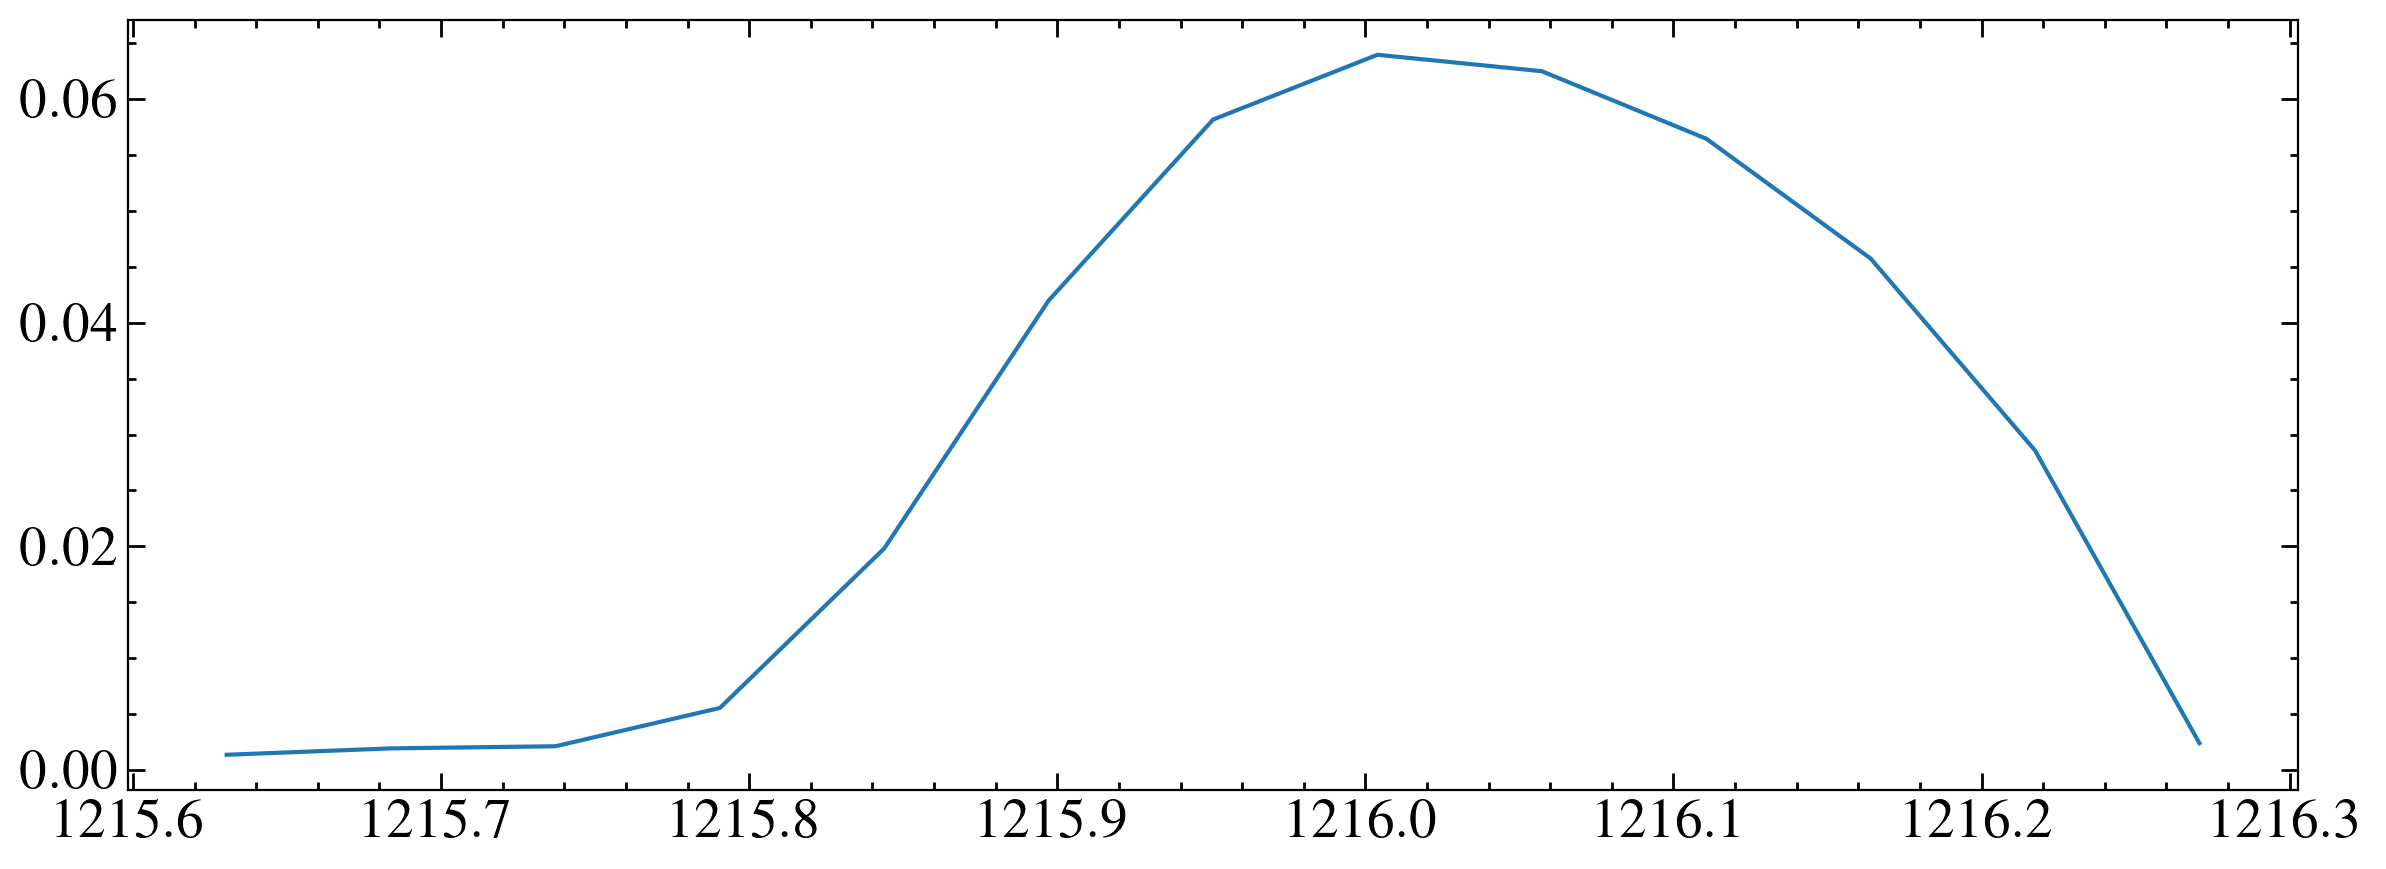

In [6]:
w = data['wave_mm']
m = data['LyA_model_median_mm']
me = data['LyA_model_high_1sig_mm']
I = data['LyA_intrinsic_profile_median_mm']
Ie = data['LyA_intrinsic_profile_high_1sig_mm']

ism = m/I

isme = (ism * (((me-m)/m)**2 - ((Ie-I)/I)**2)**0.5) #+ism

# plt.plot(w, m)
# plt.plot(w, I)
# plt.plot(w, Ie)

# plt.plot(w, (Ie-I)/I)
# plt.plot(w, (me-m)/m)

# plt.plot(w, ism)
plt.plot(w, isme)



In [7]:
plt.plot(v, (ism_up-ism)/ism)

NameError: name 'ism_up' is not defined

In [ ]:
# fig, ax=plt.subplots(figsize=(3,3))

# v = (data['wave_mm']*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
# ax.step(v, data['flux_mm']*fscale, c='C0', label = 'Observed Spectrum', zorder=0, where='mid')
# ax.errorbar(v, data['flux_mm']*fscale, yerr=data['error_mm']*fscale, alpha=0.5, errorevery=3, ls='none', c='C0')
# ax.plot(v, data['LyA_model_median_mm']*fscale, c='C1', label='Model fit', zorder=1)
# ax.fill_between(v.value, data['LyA_model_high_1sig_mm']*fscale,data['LyA_model_low_1sig_mm']*fscale, color='C1', alpha=0.5)

# ax.plot(v, data['LyA_intrinsic_profile_median_mm']*fscale, c='C2', ls='--', label=r'Intrinsic Ly$\alpha$ profile', zorder=-1)
# ax.fill_between(v.value, data['LyA_intrinsic_profile_high_1sig_mm']*fscale,data['LyA_intrinsic_profile_low_1sig_mm']*fscale, color='C2', alpha=0.5, zorder=-10)

# name = 'TRAPPIST-1'
# ax.set_title(name, size=20)


# ism = data['LyA_model_median_mm'] / data['LyA_intrinsic_profile_median_mm']
# ism_up = ism+ism*((data['LyA_intrinsic_profile_high_1sig_mm'] - data['LyA_intrinsic_profile_median_mm'])/data['LyA_intrinsic_profile_median_mm'])
# ism_dn = ism-ism*((data['LyA_intrinsic_profile_median_mm'] - data['LyA_intrinsic_profile_low_1sig_mm'])/data['LyA_intrinsic_profile_median_mm'])
# # ism_up = ism+(1-ism)*((data['LyA_model_high_1sig_mm'] - data['LyA_model_median_mm'])/data['LyA_model_median_mm'])
# # ism_dn = ism-ism*((data['LyA_model_median_mm'] - data['LyA_model_low_1sig_mm'])/data['LyA_model_median_mm'])


# xlim = min([abs(min(v.value)), max(v.value)])-10
# ax.set_xlim(-xlim, xlim)
# ax2=ax.twinx()
# ax2.plot(v, ism, c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
# ax2.fill_between(v.value, ism_up,ism_dn, color='C4', alpha=0.5, zorder=-10)
# ax2.set_ylim(-0.1, 1.05)

# fig.savefig('plots/t1_wrong2.png')